In [1]:
import numpy as np
import pandas as pd
import glob
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from ramco import Ramco


In [2]:
# reading all csv files from the dataset folder: csv_files
dataset_csv_path = './csv_files/'
csv_files_pattern = '*.csv'
full_path = os.path.join(dataset_csv_path, csv_files_pattern)
csv_files = glob.glob(full_path)
print(csv_files)

['./csv_files\\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', './csv_files\\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', './csv_files\\Friday-WorkingHours-Morning.pcap_ISCX.csv', './csv_files\\Monday-WorkingHours.pcap_ISCX.csv', './csv_files\\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', './csv_files\\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', './csv_files\\Tuesday-WorkingHours.pcap_ISCX.csv', './csv_files\\Wednesday-workingHours.pcap_ISCX.csv']


In [3]:
# loading the dataset into a pandas dataframe
df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
print("Columns in dataset are: ", df.columns)

Columns in dataset are:  Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' P

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

In [6]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [7]:
df[' Label'].nunique()

15

In [8]:
df=Ramco(df).data_cleaning()

Dataset Shape:  (2830743, 79)
Zero Variance Columns:  ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'] are dropped.
Shape after removing the zero variance columns:  (2830743, 71)
2867 rows dropped
Shape after Removing NaN:  (2827876, 71)
Shape after dropping duplicates:  (2520798, 71)
Columns which have identical values:  [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Header Length', 'Fwd Header Length.1')]  dropped!
Shape after removing identical value columns:  (2520798, 66)


In [9]:
df['Label'].value_counts()

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

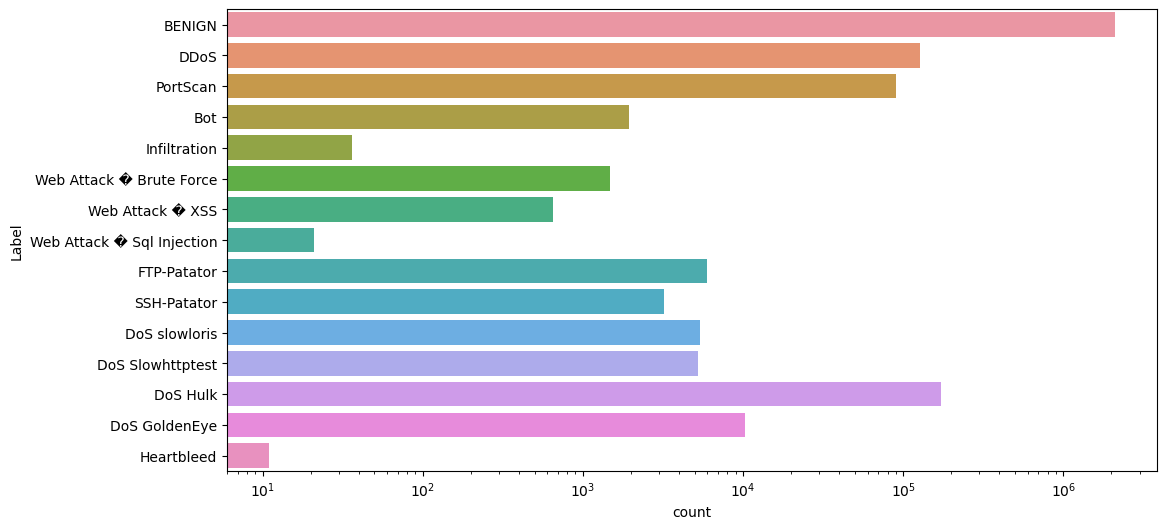

In [10]:
# plotting the count of different label values which helps us visualize 
# the frequency of different attakcs that our dataset contains
plt.figure(figsize=(12, 6))
plot = sns.countplot(data=df[df['Label'] != 'BENIGNE'], y='Label')
plt.xscale('log')
fig = plot.get_figure()
fig.savefig('img1.png')

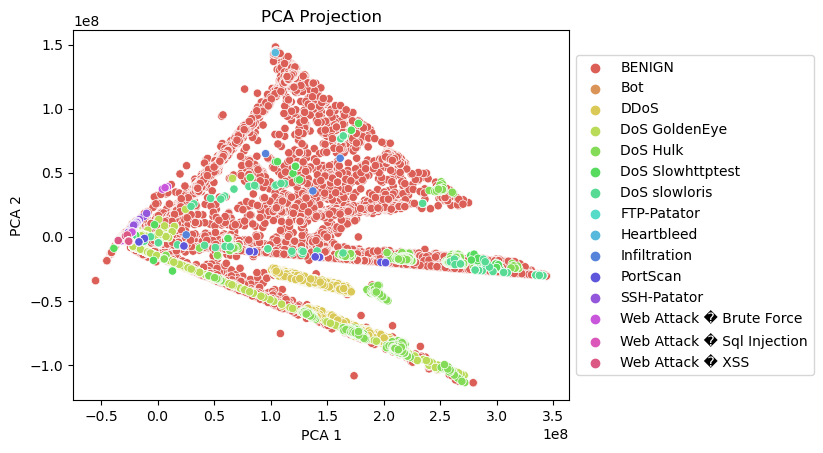

In [11]:
# data subsampling and separating features and target variables
subsample_df=df.groupby('Label').apply(pd.DataFrame.sample,frac=0.1).reset_index(drop=True)
x=subsample_df.drop(['Label'],axis=1)
y=subsample_df['Label']
# reducing the dimensionality into 2
pca=PCA(n_components=2, random_state=0)
z=pca.fit_transform(x)
# combining the principal components and labels into a DataFrame
pca_df=pd.DataFrame()
pca_df['Label']=y
pca_df['PCA 1']=z[:,0]
pca_df['PCA 2']=z[:,1]
# visualizes the data in the reduced two-dimensional space
# which allows to explore potential patterns and relationships between the features and their labels
sns.scatterplot(data=pca_df,x='PCA 1',y='PCA 2',hue='Label',palette=sns.color_palette('hls',len(pca_df.Label.value_counts()))).set_title("PCA Projection")
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.show()

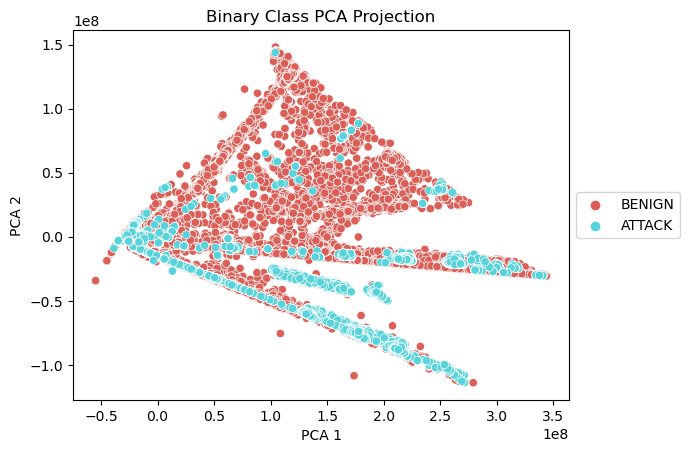

In [12]:
# renaming all different attacks to attack to allow a binary representation of the data
# the goal here is to achieve a classification of attack or benign
pca_df.loc[pca_df.Label !='BENIGN','Label']='ATTACK'
sns.scatterplot(data=pca_df,x='PCA 1',y='PCA 2',hue=pca_df.Label,palette=sns.color_palette('hls',2)).set_title("Binary Class PCA Projection")
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.show()

In [13]:
df.columns=df.columns.str.strip().str.lower().str.replace(' ','_').str.replace('(','').str.replace(')','')
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [14]:
df['label'].value_counts()

label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [15]:
new_df=df.copy()

In [16]:
df.loc[df['label']!='BENIGN','label']='ATTACK'
df.head()

,destination_port,flow_duration,total_fwd_packets,total_backward_packets,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_mean,fwd_packet_length_std,...,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [17]:
df['label'].value_counts()

label
BENIGN    2095057
ATTACK     425741
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

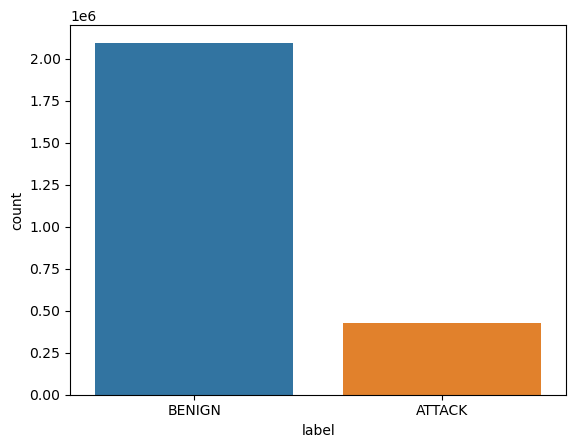

In [18]:
sns.countplot(data=df,x=df['label'])

In [19]:
# creating a data frame with balanced data
size=len(df.loc[df.label=='ATTACK'])
print(size)
bal_df=df.groupby('label').apply(lambda x: x.sample(n=min(size,len(x))))

425741


<Axes: xlabel='label', ylabel='count'>

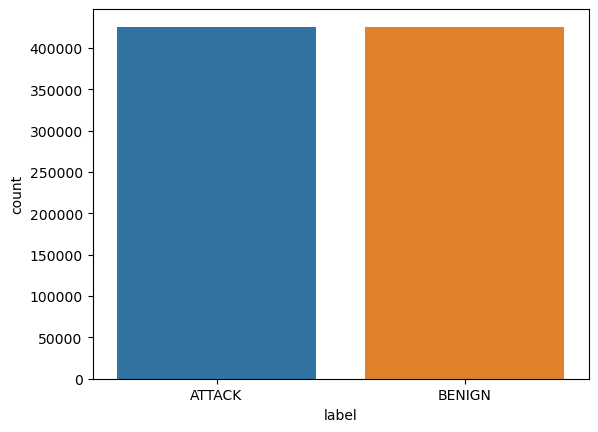

In [20]:
sns.countplot(data=bal_df,x='label')

In [21]:
bal_df.shape

(851482, 66)

In [22]:
gc.collect()

6814

In [23]:
# label encoding since we're interested in a binary representation here
bal_df.loc[bal_df['label']== 'ATTACK','label']=1
bal_df.loc[bal_df['label']=='BENIGN','label']=0

In [24]:
type(bal_df.label)

pandas.core.series.Series

In [25]:
# feature scaling and label conversion to int
# applying normalization since we have label encoding
X=bal_df.drop(columns='label')
y=bal_df['label'].astype('int')
X=MinMaxScaler().fit_transform(X)

In [26]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print(X_train.shape," ",X_test.shape)
print(y_train.shape," ",y_test.shape)

(681185, 65)   (170297, 65)
(681185,)   (170297,)


In [27]:
Xn=new_df.drop(columns='label')
Xn=MinMaxScaler().fit_transform(Xn)
yn=new_df['label']
yn=LabelEncoder().fit_transform(yn)
Xn_train,Xn_test,yn_train,yn_test=train_test_split(Xn,yn,test_size=0.2)

In [28]:
print(Xn_test.shape,Xn_train.shape)
print(yn_test.shape,yn_train.shape)

(504160, 65) (2016638, 65)
(504160,) (2016638,)


Epoch 1/20
5315/5322 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.9549
Epoch 1: val_accuracy improved from -inf to 0.96357, saving model to best_model.keras
5322/5322 [==============================] - 40s 7ms/step - loss: 0.1145 - accuracy: 0.9549 - val_loss: 0.0926 - val_accuracy: 0.9636
Epoch 2/20
5314/5322 [============================>.] - ETA: 0s - loss: 0.0805 - accuracy: 0.9685
Epoch 2: val_accuracy improved from 0.96357 to 0.97387, saving model to best_model.keras
5322/5322 [==============================] - 37s 7ms/step - loss: 0.0805 - accuracy: 0.9684 - val_loss: 0.0705 - val_accuracy: 0.9739
Epoch 3/20
5318/5322 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9725
Epoch 3: val_accuracy improved from 0.97387 to 0.97406, saving model to best_model.keras
5322/5322 [==============================] - 40s 7ms/step - loss: 0.0708 - accuracy: 0.9725 - val_loss: 0.0673 - val_accuracy: 0.9741
Epoch 4/20
5317/5322 [==================

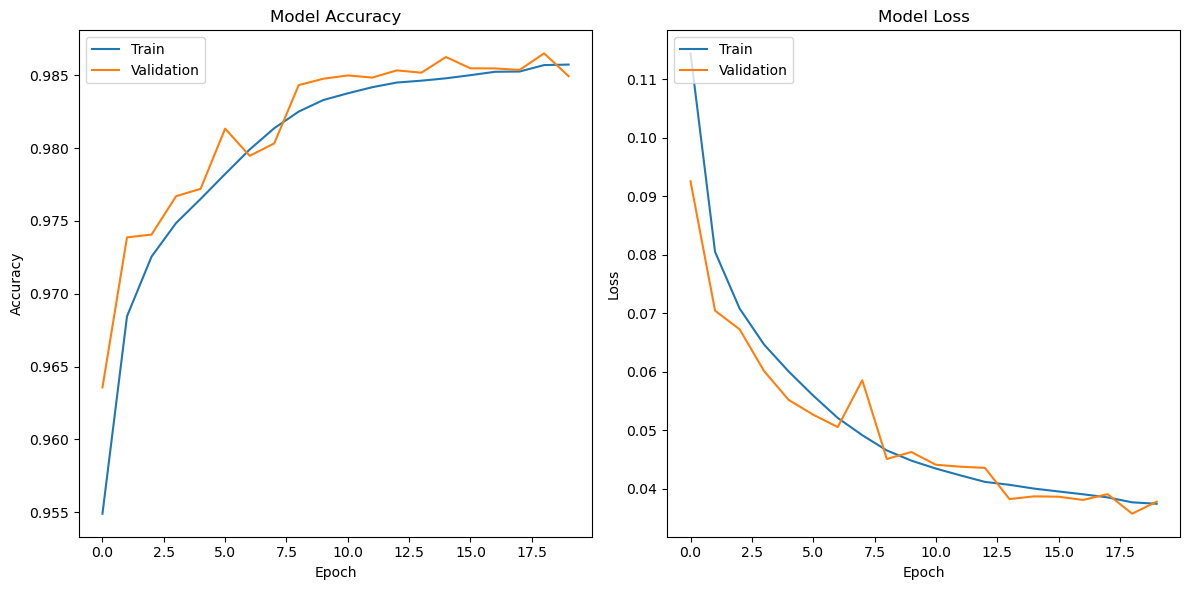

5322/5322 [==============================] - 18s 3ms/step - loss: 0.0378 - accuracy: 0.9849
Test Loss: 0.03782070800662041, Test Accuracy: 0.9849321842193604
5322/5322 [==============================] - 19s 4ms/step


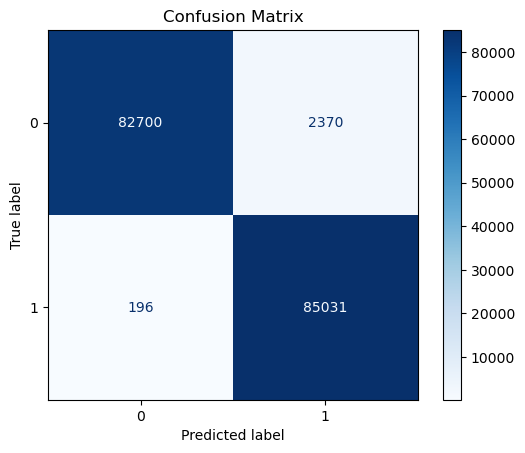

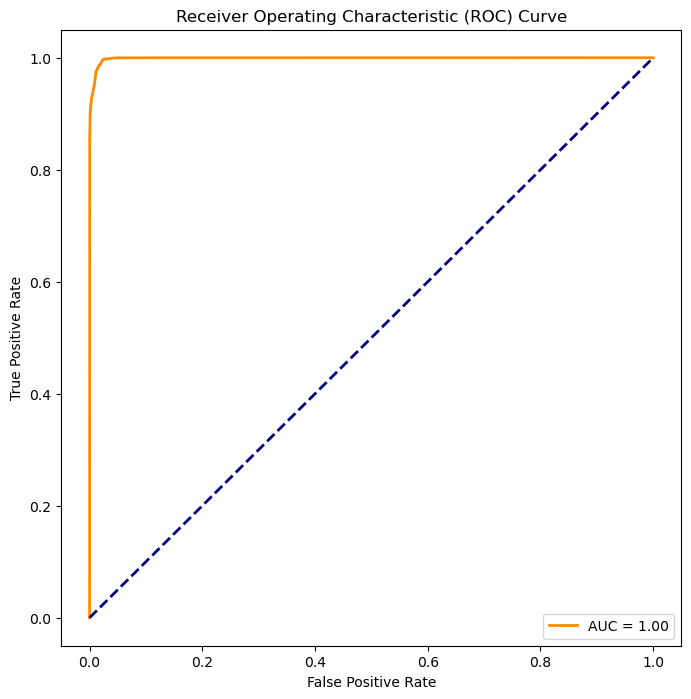

In [29]:


def train_and_evaluate_cnn(X_train, y_train, X_test, y_test):
    # Reshape data for CNN (assuming your data is 2D, modify accordingly)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Define callbacks
    callbacks = [
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ]

    # Train the model with callbacks
    history = model.fit(
        X_train, y_train, 
        epochs=20, 
        batch_size=128, 
        validation_data=(X_test, y_test),
        callbacks=callbacks
    )

    # Plot training history
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

    # Confusion Matrix
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)  
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Load the best model
    best_model = load_model('best_model.keras')

    return best_model

# Usage
best_model = train_and_evaluate_cnn(X_train, y_train, X_test, y_test)
